In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
data=pd.read_csv('/content/drive/MyDrive/modeldata.csv')

In [4]:
X = data.iloc[: ,:-1].values
Y = data['emo'].values

In [5]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7046, 801), (7046, 5), (2349, 801), (2349, 5))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7046, 801), (7046, 5), (2349, 801), (2349, 5))

In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7046, 801, 1), (7046, 5), (2349, 801, 1), (2349, 5))

In [9]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 801, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 401, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 401, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 201, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 201, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 101, 128)         0

In [10]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [11]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
111/111 [==============================] - 217s 2s/step - loss: 1.5804 - accuracy: 0.2320 - val_loss: 1.5660 - val_accuracy: 0.2520 - lr: 1.0000e-04
Epoch 2/60
111/111 [==============================] - 216s 2s/step - loss: 1.5634 - accuracy: 0.2563 - val_loss: 1.5603 - val_accuracy: 0.2916 - lr: 1.0000e-04
Epoch 3/60
111/111 [==============================] - 210s 2s/step - loss: 1.5532 - accuracy: 0.2604 - val_loss: 1.5519 - val_accuracy: 0.2950 - lr: 1.0000e-04
Epoch 4/60
111/111 [==============================] - 207s 2s/step - loss: 1.5483 - accuracy: 0.2689 - val_loss: 1.5482 - val_accuracy: 0.2908 - lr: 1.0000e-04
Epoch 5/60
111/111 [==============================] - 205s 2s/step - loss: 1.5417 - accuracy: 0.2716 - val_loss: 1.5488 - val_accuracy: 0.2669 - lr: 1.0000e-04
Epoch 6/60
111/111 [==============================] - 205s 2s/step - loss: 1.5375 - accuracy: 0.2857 - val_loss: 1.5276 - val_accuracy: 0.3035 - lr: 1.0000e-04
Epoch 7/60
111/111 [====================

74/74 [==============================] - 15s 204ms/step - loss: 1.4008 - accuracy: 0.4304
Accuracy of our model on test data :  43.03959012031555 %


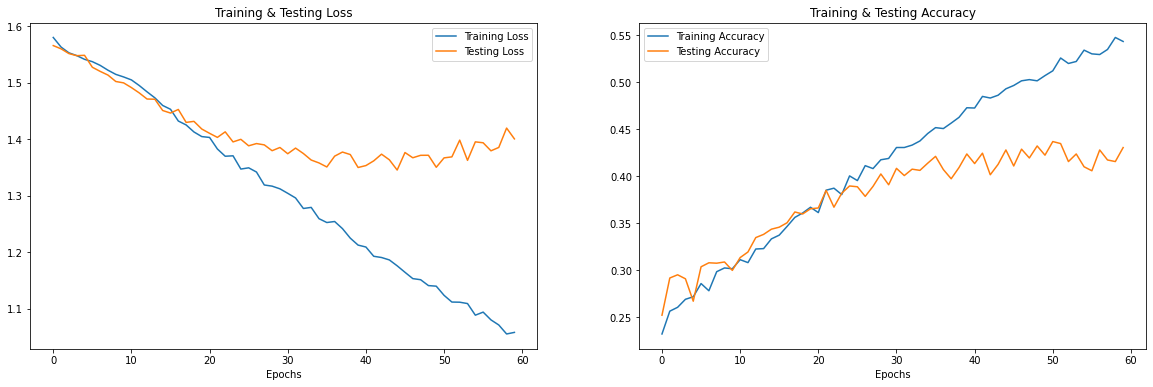

In [12]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [13]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

74/74 [==============================] - 20s 265ms/step


In [14]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,3,3
1,0,1
2,4,1
3,4,1
4,5,3
5,3,5
6,1,1
7,5,5
8,3,3
9,3,4


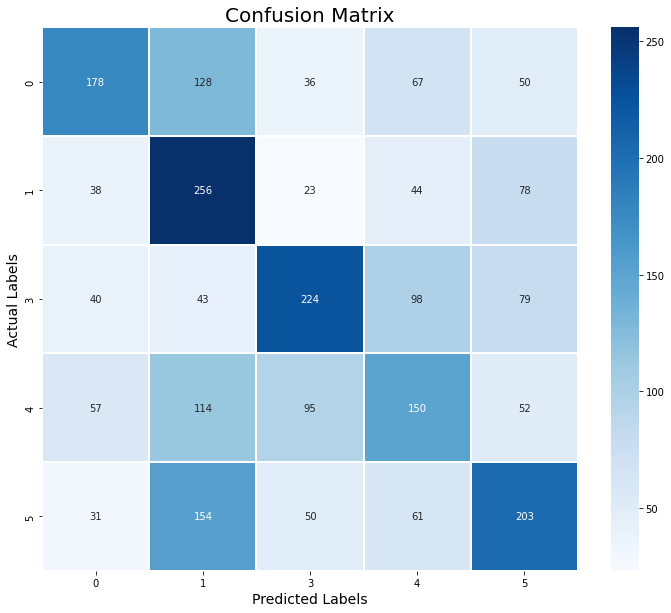

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.39      0.44       459
           1       0.37      0.58      0.45       439
           3       0.52      0.46      0.49       484
           4       0.36      0.32      0.34       468
           5       0.44      0.41      0.42       499

    accuracy                           0.43      2349
   macro avg       0.44      0.43      0.43      2349
weighted avg       0.44      0.43      0.43      2349

